# ML for prediction GRB redshift. 

Data was taken from https://user-web.icecube.wisc.edu/~grbweb_public/index.html

## Libs

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data splitters, scalers and error calc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix#,classification_report

#models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
# from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
# from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
# from sklearn.svm import SVC
from sklearn.svm import SVR,LinearSVR
from sklearn.tree import DecisionTreeRegressor
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor 
# from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
# from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor 
# from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

## Data

In [2]:
# Compatible with both python 2.7 & python 3
#    Make sure pandas is installed using: pip install --user pandas; pip3 install --user pandas;
from __future__ import print_function
import sqlite3
import requests

# Download the SQLite file from the GRBweb webpage
r = requests.get("https://icecube.wisc.edu/~grbweb_public/GRBweb2.sqlite")
f = open('GRBweb2.sqlite', 'wb').write(r.content)

# Load the database with the sqlite3 module
db = sqlite3.connect('GRBweb2.sqlite')

# Print the names of all the tables
table_names = pd.read_sql_query("SELECT * from sqlite_sequence", db)
print("Table names:\n", table_names, "\n\n")

# From the list of table names, select the one you wish to load.
#    For example, we will here load the Swift table.
Swift_table = pd.read_sql_query("SELECT * from Swift", db)
Swift_table = Swift_table.sort_values("GRB_name")
print("Swift table:\n", Swift_table, "\n\n")

# Print the first entry in the Swift table
print("First entry in Swift table:")
keys = Swift_table.keys()
First_entry = Swift_table.values[0]
for key, value in zip(keys, First_entry):
    print("{:>12}:  {:<25}".format(key, value))

# Get numpy arrays containing the right ascension, declination, mjd, ...
#    of the entries in the Summary table
Summary_table = pd.read_sql_query("SELECT * from Summary", db)
keys = Summary_table.keys()
print("\n\nKeys in the 'Summary' table:", list(keys))
RA  = np.array(Summary_table.ra)   # right ascension
DEC = np.array(Summary_table.decl) # declination
MJD = np.array(Summary_table.mjd)  # modified julian date
print(" RA:", RA)
print(" DEC:", DEC)
print(" MJD:", MJD)


Table names:
                       name    seq
0                    BATSE   2702
1                 BeppoSAX   1082
2                Fermi_GBM   3139
3  Fermi_GBM_precursor_Zhu    239
4   Fermi_GBM_subthreshold   4623
5                Fermi_LAT    146
6            GCN_circulars  18538
7                      IPN   2263
8                  Summary   7661
9                    Swift   1506 


Swift table:
         id    GRB_name  t_trigger          ra       decl  pos_error     T90  \
1304  1305  GRB041217A   26905.00  164.793000 -17.942000   0.010096    5.80   
1303  1304  GRB041219A    6138.00    6.154000  62.847000   0.054366  520.00   
1302  1303  GRB041219B   56328.00  167.674000 -33.458000   0.054366   30.00   
1301  1302  GRB041219C   73834.00  343.926000 -76.744000   0.007767    4.80   
1300  1301  GRB041220A   82707.00  291.288000  60.598000   0.007767    5.60   
...    ...         ...        ...         ...        ...        ...     ...   
1488  1502  GRB210824A   15001.00  232.105

In [3]:
Summary_table

,id,GRB_name,GRB_name_Fermi,T0,T0_source,ra,ra_source,decl,decl_source,pos_error,...,fluence,fluence_source,fluence_error,fluence_error_source,redshift,redshift_source,T100,GBM_located,mjd,mjd_source
0,1,GRB150702A,GRB150702998,86197.550,Fermi_LAT,52.780000,Fermi_LAT,-57.000000,Fermi_LAT,0.360000,...,1.174100e-05,Fermi_GBM,5.402800e-08,Fermi_GBM,NaN,None,48.170,0,57205.997657,Fermi_LAT
1,2,GRB080120A,None,62910.000,"GCN_circulars,INTEGRAL",225.287500,IPN,-10.900000,IPN,0.051667,...,NaN,None,NaN,None,NaN,None,NaN,0,54485.728125,"GCN_circulars,INTEGRAL"
2,3,GRB080123A,None,15717.000,"GCN_circulars,Swift Det",338.943083,Swift,-64.900889,Swift,0.000220,...,5.700000e-07,Swift,NaN,None,NaN,None,115.000,0,54488.181910,"GCN_circulars,Swift Det"
3,4,GRB080121A,None,77395.000,Swift,137.235000,Swift,41.841000,Swift,0.023300,...,3.000000e-08,Swift,NaN,None,0.046,"GCN_circulars,Swift-BAT Det",0.700,0,54486.895775,Swift
4,5,GRB080122A,None,66764.000,"GCN_circulars,IPN Triangulation",191.350000,IPN,27.016667,IPN,1.666667,...,NaN,None,NaN,None,NaN,None,NaN,0,54487.772731,"GCN_circulars,IPN Triangulation"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656,7657,GRB960615C,None,86315.873,BATSE,295.475000,BATSE,-65.966667,BATSE,7.450000,...,3.345300e-08,BATSE,4.910364e-09,BATSE,NaN,None,0.624,0,50249.999026,BATSE
7657,7658,GRB961228C,None,86315.728,BATSE,4.150000,BATSE,-59.066667,BATSE,1.000000,...,1.009380e-05,BATSE,8.924738e-08,BATSE,NaN,None,60.032,0,50445.999025,BATSE
7658,7659,GRB940728C,None,86334.100,BATSE,85.500000,BATSE,-39.866667,BATSE,1.440000,...,1.818420e-06,BATSE,4.840909e-08,BATSE,NaN,None,37.696,0,49561.999237,BATSE
7659,7660,GRB990407B,None,86340.100,BATSE,266.700000,BATSE,49.083333,BATSE,1.620000,...,NaN,None,NaN,None,NaN,None,NaN,0,51275.999307,BATSE


In [4]:
Summary_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7661 entries, 0 to 7660
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7661 non-null   int64  
 1   GRB_name              7661 non-null   object 
 2   GRB_name_Fermi        3132 non-null   object 
 3   T0                    7661 non-null   float64
 4   T0_source             7661 non-null   object 
 5   ra                    7661 non-null   float64
 6   ra_source             7661 non-null   object 
 7   decl                  7661 non-null   float64
 8   decl_source           7658 non-null   object 
 9   pos_error             7438 non-null   float64
 10  pos_error_source      7438 non-null   object 
 11  T90                   6687 non-null   float64
 12  T90_source            6687 non-null   object 
 13  T90_error             5701 non-null   float64
 14  T90_error_source      5701 non-null   object 
 15  T90_start            

In [5]:
Summary_table.columns

Index(['id', 'GRB_name', 'GRB_name_Fermi', 'T0', 'T0_source', 'ra',
       'ra_source', 'decl', 'decl_source', 'pos_error', 'pos_error_source',
       'T90', 'T90_source', 'T90_error', 'T90_error_source', 'T90_start',
       'T90_start_source', 'fluence', 'fluence_source', 'fluence_error',
       'fluence_error_source', 'redshift', 'redshift_source', 'T100',
       'GBM_located', 'mjd', 'mjd_source'],
      dtype='object')

In [ ]:
data = Summary_table['GRB_name','T0', 'ra', 'T90', 'fluence', 'GBM_located', 'mjd', 'mjd_source']

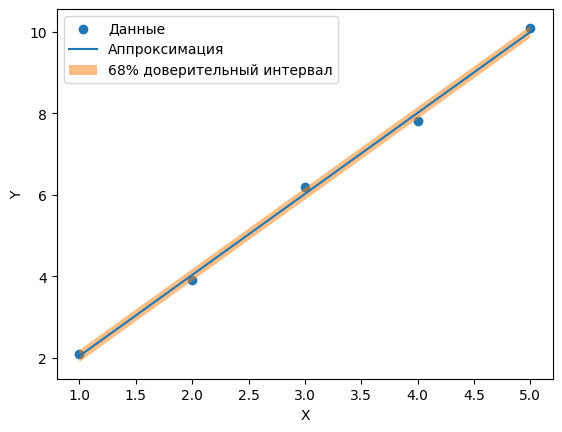

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Создаем данные для аппроксимации (пример)
x = np.array([1, 2, 3, 4, 5])
y = np.array([2.1, 3.9, 6.2, 7.8, 10.1])

# Выполняем аппроксимацию полиномом первого порядка (линейная регрессия)
coefficients = np.polyfit(x, y, 1)
poly = np.poly1d(coefficients)

# Вычисляем стандартную ошибку оценки коэффициентов
residuals = y - poly(x)
std_error = np.std(residuals)

# Задаем уровень доверия (например, 1 сигма - примерно 68%)
confidence_level = 0.68

# Вычисляем границы доверительного интервала
lower_bound = poly(x) - std_error
upper_bound = poly(x) + std_error

# Строим график данных
plt.scatter(x, y, label="Данные")

# Строим аппроксимацию
plt.plot(x, poly(x), label="Аппроксимация")

# Строим пределы в один сигма
plt.fill_between(x, lower_bound, upper_bound, alpha=0.5, label=f"{int(confidence_level*100)}% доверительный интервал")

# Добавляем легенду и подписи осей
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")

# Отображаем график
plt.show()

